In [1]:
import pandas as pd
from src.utils import MySQLAgent, OracleAgent
# from src.plot_tools import cat_value_count_bar_plot, num_value_count_bar_plot
import json
from datetime import datetime

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

### Helper functions

In [2]:
def cat_value_count_bar_plot(df, column, color, title, xlabel, y_label):
    # Calculate the distribution of 'is_improve'
    distribution = df[column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()


In [3]:
def num_value_count_bar_plot(df, column, color, title, xlabel, ylabel):
    df[column] = df[column].astype('int')
    distribution = df[column].sort_values().value_counts(sort=False)  # Sort the values by index

    # Create a bar plot
    plt.figure(figsize=(6, 4))  # Adjust figure size as needed
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()

In [4]:
def read_config(path):
    try:
        with open(path, 'r') as file:
            configs = json.load(file)

        return configs
    except FileNotFoundError:
        print(f"The file {path} was not found.")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from the file {path}.")

In [5]:
configs = read_config(path="./conn/connections.json")
job_configs = configs["CREDITREPORT"]['VM1_mysql_conn_info']
sql_agent = MySQLAgent(job_configs)

In [6]:
query = """
    select * from company
"""
df_company = sql_agent.read_table(query=query)
df_company.head()

,business_accounting_no,company_name,internal_id,query_name
0,00700019,國昌綜合工廠有限公司,K7913,None
1,00713181,華聯食品工業股份有限公司,J5984,None
2,00784930,建寶食品股份有限公司,K4395,None
3,00966299,財團法人台北市瑠公農業產銷基金會,K9232,None
4,01055919,新光醫療財團法人,K1282,None


In [7]:
i = 0
# company = df_company.iloc[i]
company = df_company[df_company['business_accounting_no'] == '27450696']
company_account = company.business_accounting_no.values[0]
company_name = company.company_name.values[0]
internal_id = company.internal_id.values[0]
company_account

'27450696'

In [8]:
company

,business_accounting_no,company_name,internal_id,query_name
3454,27450696,日月千禧酒店股份有限公司,K3844,None


#### companyinfo01

- 企業狀態
- 地址關聯
- 資本額(Captial_Stock_Amount)
- 最近更新日期

In [9]:
try:
    query = f"""
        select * from companyinfo01
        where Business_Accounting_No = {company_account}
    """
    companyinfo01 = sql_agent.read_table(query=query)
    companyinfo01.head()
except Exception as e:
    print("An error occurred:", e)


In [10]:
companyinfo01

,business_accounting_no,company_status_desc,company_name,capital_stock_amount,paid_in_capital_amount,responsible_name,company_location,register_organization_desc,company_setup_date,change_of_approval_data,revoke_app_date,case_status,case_status_desc,sus_app_date,sus_beg_date,sus_end_date,createtime,updatetime
0,27450696,核准設立,日月千禧酒店股份有限公司,800000000,700000000,張重興,臺中市西屯區市政路77號,經濟部商業司,0930923,1110428,,,,,,,2024-01-29 06:57:38,2024-03-08 20:02:34


In [11]:
# 公司狀態
company_status = companyinfo01['company_status_desc'].values[0]

# 地址關聯 - neo4j

# 資本額
company_captial = companyinfo01['capital_stock_amount'].values[0]

#### EPA

In [12]:
query = f"""
select * from epa_ems_p_46
where Business_Accounting_No = {company_account}
"""
df_epa = sql_agent.read_table(query=query)
df_epa.columns = df_epa.columns.str.lower()
df_epa.head()

,business_accounting_no,ems_no,fac_name,county_name,document_no,transgress_date,transgress_law,penalty_money,penalty_date,ispetition,...,is_improve,inspection_datetime_s,penaltykind,isimportant,paymentstate,isreminder,isadmincourt,isreducemoney,createtime,updatetime
0,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-101-110001,2012-08-28,環境影響評估法第17條,300000,2012-11-16,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
1,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-107-010001,2017-11-10,環境影響評估法第17條,300000,2018-01-02,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
2,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-060013,2013-05-14,空氣污染防制法第20條第1款,100000,2013-06-17,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
3,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-110014,2013-09-16,空氣污染防制法第20條第1項,200000,2013-11-11,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
4,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,41-101-100702,2012-08-15,廢棄物清理法第27條第2款,4500,2012-10-11,0,...,已改善完成,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17


In [13]:
if df_epa.size == 0:
    print(f'{company_name} 沒有環保署裁處紀錄。')

In [14]:
df_epa[['document_no', 'is_improve']]

,document_no,is_improve
0,10-101-110001,不須改善
1,10-107-010001,不須改善
2,20-102-060013,已改善完成
3,20-102-110014,已改善完成
4,41-101-100702,已改善完成


In [15]:
df_epa.sort_values('penalty_date', ascending=True)

,business_accounting_no,ems_no,fac_name,county_name,document_no,transgress_date,transgress_law,penalty_money,penalty_date,ispetition,...,is_improve,inspection_datetime_s,penaltykind,isimportant,paymentstate,isreminder,isadmincourt,isreducemoney,createtime,updatetime
4,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,41-101-100702,2012-08-15,廢棄物清理法第27條第2款,4500,2012-10-11,0,...,已改善完成,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
0,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-101-110001,2012-08-28,環境影響評估法第17條,300000,2012-11-16,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
2,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-060013,2013-05-14,空氣污染防制法第20條第1款,100000,2013-06-17,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
3,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-110014,2013-09-16,空氣污染防制法第20條第1項,200000,2013-11-11,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
1,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-107-010001,2017-11-10,環境影響評估法第17條,300000,2018-01-02,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17


In [16]:
# 共有幾筆紀錄
row_count = df_epa.shape[0]

# 最高裁處金額
max_penalty_money = df_epa['penalty_money'].max()

# 近期裁處金額
df_epa['penalty_date'] = pd.to_datetime(df_epa['penalty_date'])
latest_penalty_money = df_epa.loc[df_epa['penalty_date'] == df_epa['penalty_date'].max(), 'penalty_money'].values[0]


In [17]:
# is_improve分布
# cat_value_count_bar_plot(df_epa, 'is_improve', 'skyblue', '環保署裁處後的改善情況', '改善情況類別', '次數')

In [18]:
# penaltykind分布
# cat_value_count_bar_plot(df_epa, 'penaltykind', 'skyblue', '環保署裁處類別分布', '裁處類別', '次數')

In [19]:
# 裁處金額分布
# num_value_count_bar_plot(df_epa, 'penalty_money', 'skyblue', '環保署裁處金額分布', '裁處金額', '次數')

### PST

In [20]:
configs = read_config(path="./conn/connections.json")
job_configs = configs["CREDITREPORT"]['BIDB_conn_info']
job_configs

{'user': 'ODS_USER1',
 'pw': 'Yfy12345',
 'host': 'yfybiappsdb.yfy.com',
 'port': 1521,
 'database': 'biprod'}

In [21]:
configs = read_config(path="./conn/connections.json")
job_configs = configs["CREDITREPORT"]['BIDB_conn_info']
oracle_agent = OracleAgent(job_configs)

In [22]:
query = f"""
select * from ODS.w_yfy_crd_pst_f

"""
# where debtor_accounting_no = '{company_account}'
df_pst = oracle_agent.read_table(query=query)
df_pst['agreement_end_date'] = pd.to_datetime(df_pst['agreement_end_date'])

In [23]:
df_pst.secured_type.value_counts()

secured_type
無動產抵押資料    19154
動產抵押        4430
附條件買賣        596
Name: count, dtype: int64

In [24]:
df_pst.currency.value_counts()

currency
新台幣    4965
日圓        8
美金        6
Name: count, dtype: int64

In [25]:
# df_pst[df_pst['currency'] == '日圓']

In [26]:
df1 = df_pst[df_pst['secured_type'] == '動產抵押']
df1.columns

Index(['register_organization_desc', 'register_no', 'change_no',
       'annulment_no', 'secured_type', 'register_date', 'change_date',
       'annyulment_date', 'debtor_title', 'debtor_accounting_no',
       'debtor_substitute_title', 'debtor_substitute_acct_no',
       'creditor_title', 'creditor_accounting_no', 'creditor_substitute_title',
       'creditor_substitute_acct_no', 'agreement_start_date',
       'object_owner_desc', 'object_owner_accounting_no', 'object_location',
       'is_max_limit', 'object_type', 'agreement_end_date', 'agreement_amount',
       'property_count', 'is_floating_lien', 'creation_dt', 'update_dt',
       'datasource_num_id', 'other_memo', 'currency', 'datatype'],
      dtype='object')

In [27]:
# ? is_floating_lien

df1[['debtor_title', 'debtor_accounting_no',
       'creditor_title', 'creditor_accounting_no', 'creditor_substitute_title',
        'object_location','is_max_limit', 'object_type', 'agreement_end_date', 'agreement_amount',
       'property_count', 'creation_dt', 'update_dt',
        'currency', 'datatype','datasource_num_id']].head()

,debtor_title,debtor_accounting_no,creditor_title,creditor_accounting_no,creditor_substitute_title,object_location,is_max_limit,object_type,agreement_end_date,agreement_amount,property_count,creation_dt,update_dt,currency,datatype,datasource_num_id
0,玠積國際有限公司,59229348,瑞興商業銀行股份有限公司,28417921,李彥蒲,811-高雄市楠梓區加仁路１２１號一、二、三樓,None,1、汽車、大型重型機器腳踏車及拖車,2033-07-26,960000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件,19518
2,新奇化工工業社,59239275,和潤企業股份有限公司,16844548,陳沛汝,502-彰化縣芬園鄉溪頭村彰南路一段１０３巷４４號,None,1、汽車、大型重型機器腳踏車及拖車,2038-01-18,1160000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件,19522
3,莊記綠豆鑽食品有限公司,59241856,中租迪和股份有限公司,05072925,None,高雄市鳳山區鳳仁路97-71號,是,1、機器設備或工具,2052-12-01,7200000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件,19523
4,廣泰利食品有限公司,59244798,中租迪和股份有限公司,05072925,None,高雄市鳳山區鎮北里鳳仁路93-51號,是,1、機器設備或工具,2049-12-31,3600000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件,19524
14,廣泰利食品有限公司,59244798,合作金庫商業銀行股份有限公司,70799128,None,高雄市鳳山區鳳仁路93-51號,是,1、機器設備或工具,2040-04-23,1920000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件,19525


Pst in past

In [28]:
df_pst_past = df1[df1['agreement_end_date'] <= datetime.now()]

In [29]:
df_pst_past[['debtor_title', 'agreement_end_date', 'datasource_num_id']]

,debtor_title,agreement_end_date,datasource_num_id
17,元祥金屬工業股份有限公司,2009-02-01,19528
18,元祥金屬工業股份有限公司,2008-09-01,19529
19,元祥金屬工業股份有限公司,2007-09-08,19530
39,永裕塑膠工業股份有限公司,2016-09-20,19960
43,東陽實業廠股份有限公司,2016-11-06,19964
...,...,...,...
24037,長麒金屬工業股份有限公司,2016-01-18,23474
24038,長麒金屬工業股份有限公司,2009-11-14,23475
24039,長麒金屬工業股份有限公司,2008-09-19,23476
24052,金上吉塑膠股份有限公司,2018-05-07,23488


In [30]:
# df_pst_past

In [31]:
def portion_pie_plot(df, target_column, title):
    type_counts = {type: df[target_column].count() for type in set(df[target_column])}

    labels = type_counts.keys()
    sizes = type_counts.values()

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(title)
    plt.show()

    # img_buf = io.BytesIO()
    # plt.savefig(img_buf, format='png')
    # img_buf.seek(0)
    # plt.close('all')

    # return img_buf


In [32]:
# portion_pie_plot(df_test, 'object_type', '抵押品類別分布')

In [33]:
df_pst_past_test = df1[df1['debtor_title'] == '三芳化學工業股份有限公司']
df_test = df_pst_past_test[['debtor_title', 'agreement_end_date', 'datasource_num_id']]
df_pst_past_test.head()

,register_organization_desc,register_no,change_no,annulment_no,secured_type,register_date,change_date,annyulment_date,debtor_title,debtor_accounting_no,...,agreement_end_date,agreement_amount,property_count,is_floating_lien,creation_dt,update_dt,datasource_num_id,other_memo,currency,datatype
21612,高雄市政府經濟發展局,工(中)動字第073846號,None,None,動產抵押,2002/08/27,None,None,三芳化學工業股份有限公司,83387850,...,2012-08-23,60000000.0,5.0,否,2023/09/15,2023/09/15,21636,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,新台幣,公示案件
21613,高雄市政府經濟發展局,工(中)動字第059416號,None,None,動產抵押,1998/09/25,None,None,三芳化學工業股份有限公司,83387850,...,2003-09-22,7585000.0,13.0,否,2023/09/15,2023/09/15,21637,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,美金,公示案件
21614,高雄市政府經濟發展局,工(中)動字第052741號,None,None,動產抵押,1996/12/19,None,None,三芳化學工業股份有限公司,83387850,...,2006-10-24,173000000.0,4.0,否,2023/09/15,2023/09/15,21638,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,新台幣,公示案件
21615,高雄市政府經濟發展局,工(中)動字第049413號,475070,None,動產抵押,1995/11/16,1996/12/19,None,三芳化學工業股份有限公司,83387850,...,1996-10-24,126000000.0,2.0,否,2023/09/15,2023/09/15,21639,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,新台幣,公示案件
21616,高雄市政府經濟發展局,工(中)動字第047878號,None,None,動產抵押,1995/05/13,None,None,三芳化學工業股份有限公司,83387850,...,2010-04-06,139000000.0,13.0,否,2023/09/15,2023/09/15,21640,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,新台幣,公示案件


In [34]:
df_pst_past_test[['debtor_title','agreement_end_date', 'currency', 'agreement_amount']]

,debtor_title,agreement_end_date,currency,agreement_amount
21612,三芳化學工業股份有限公司,2012-08-23,新台幣,60000000.0
21613,三芳化學工業股份有限公司,2003-09-22,美金,7585000.0
21614,三芳化學工業股份有限公司,2006-10-24,新台幣,173000000.0
21615,三芳化學工業股份有限公司,1996-10-24,新台幣,126000000.0
21616,三芳化學工業股份有限公司,2010-04-06,新台幣,139000000.0
21699,三芳化學工業股份有限公司,2004-06-10,日圓,456000000.0
21700,三芳化學工業股份有限公司,2007-12-28,新台幣,217936630.0
21701,三芳化學工業股份有限公司,1983-10-21,新台幣,30000000.0


In [35]:
df_pst_past_test.groupby(['currency'])['agreement_amount'].agg(total_amount='sum').astype('int64').unstack()

              currency
total_amount  新台幣         745936630
              日圓          456000000
              美金            7585000
dtype: int64

In [46]:
# analyze the pre- and post-timepoint pst data with identical functions
def pst_analysis(df, time_config, year_region):

    # test case: 三芳化學工業股份有限公司


    current_year = datetime.now().year
    
    if time_config == 'past':
        if df['agreement_end_date'].max() < datetime.now():
            df_sliced = df[df['agreement_end_date'] <= datetime.now()]
            years_range = list(range(current_year - year_region, current_year))
            # for past : max
            nearest_end_date = df_sliced['agreement_end_date'].max()
        elif df['agreement_end_date'].max() > datetime.now():
            return print('No pass data.')
        
    elif time_config == 'future':
        if df['agreement_end_date'].min() >= datetime.now():
            df_sliced = df[df['agreement_end_date'] > datetime.now()]
            years_range = list(range(current_year, current_year +  year_region))
            # for future: min
            nearest_end_date = df_sliced['agreement_end_date'].min()

        elif df['agreement_end_date'].min() < datetime.now():
            return print('No future data')
        
    else:
        return print('wrong time config for pst_analysis')


    # show in terms of different currency
    total_agreement_currency = df_sliced.groupby(['debtor_title','currency'])['agreement_amount'].agg(total_amount='sum').astype('int64')


    # portion of object_type
    portion_pie_plot(df_sliced, 'object_type', '抵押品類別分布')
        


    # count times by agreement_end_date in terms of year
    data_year = [date.year for date in df_sliced['agreement_end_date']]
    counts = {year: 0 for year in years_range}
    for year in data_year:
        if year in counts:
            counts[year] += 1
    years = list(counts.keys())
    values = list(counts.values())
    plt.figure(figsize=(10, 6))
    plt.plot(years, values, marker='o', linestyle='-', color='blue')
    if time_config == 'past':
        plt.title(f'過去{year_region}年逐年動產擔保到期次數')
    elif time_config == 'future':
        plt.title(f'未來{year_region}年逐年動產擔保到期次數')
    plt.xlabel('年')
    plt.ylabel('次數')
    plt.xticks(years)
    plt.grid(True)
    plt.show()
    
    # line_plot = io.BytesIO()
    # plt.savefig(line_plot, format='png')
    # line_plot.seek(0)
    # plt.close('all')

    # return line_plot

    return total_agreement_currency, nearest_end_date

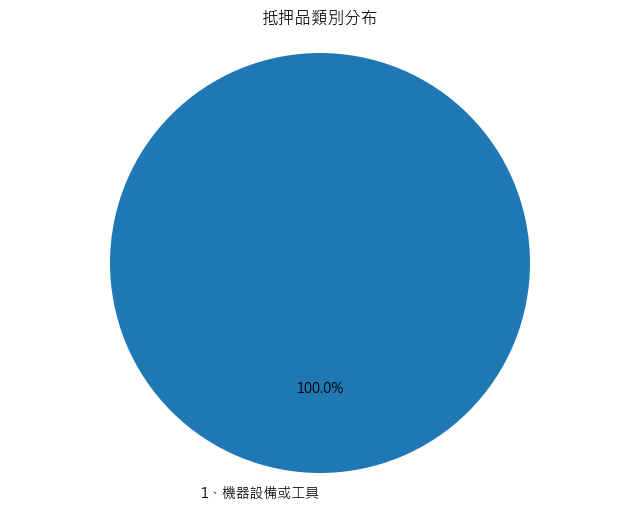

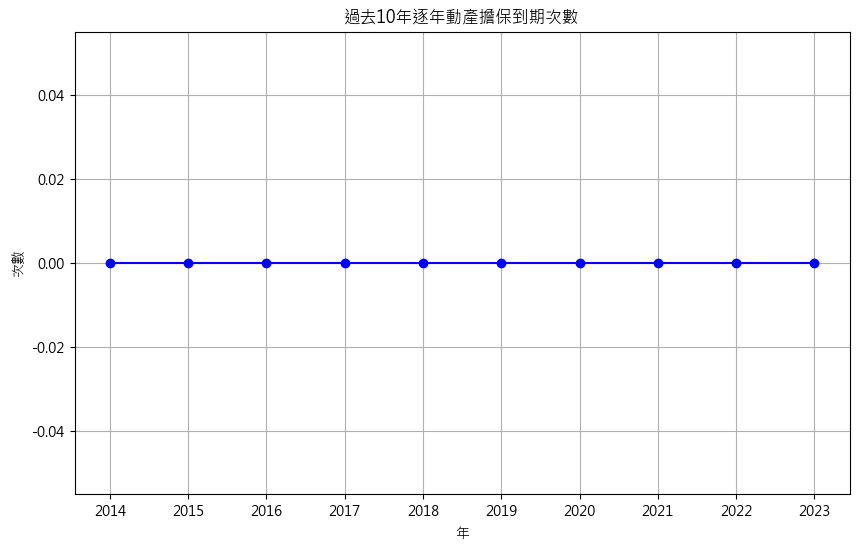

In [51]:
total_agreement_currency, nearest_end_date = pst_analysis(df_pst_past_test, 'past', 10)

In [52]:
total_agreement_currency

total_amount
debtor_title currency              
三芳化學工業股份有限公司 新台幣          745936630
             日圓           456000000
             美金             7585000

In [38]:
current_year = datetime.now().year
years_range = list(range(current_year-5, current_year+1))
years_range

[2019, 2020, 2021, 2022, 2023, 2024]

In [39]:
# total agreement_amount
total_agreement = df_pst_past.agreement_amount.sum().astype('int64')

# the nearest end_date
nearest_end_date = df_pst_past['agreement_end_date'].max()

# the nearest agreement_amount
nearest_agreement_amount = df_pst_past.loc[df_pst_past['agreement_end_date'] == df_pst_past['agreement_end_date'].max(), 'agreement_amount'].values[0].astype('int64')
nearest_agreement_amount

# 

# detail data?

0

In [40]:
def cat_value_count_bar_plot(df, column, color, title, xlabel, y_label):
    # Calculate the distribution of 'is_improve'
    distribution = df[column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')


    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()

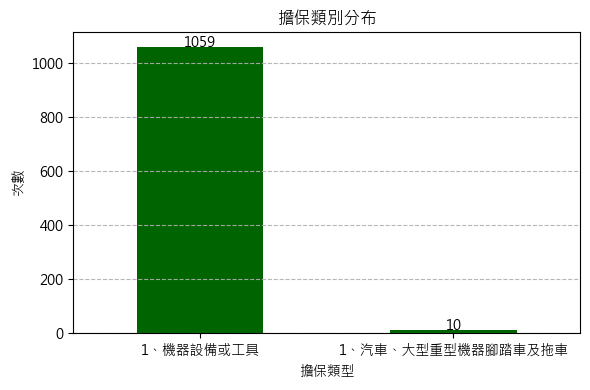

In [41]:
# object_type distribution
cat_value_count_bar_plot(df_pst_past, 'object_type', 'darkgreen', '擔保類別分布', '擔保類型', '次數')

In [42]:
# cat_value_count_bar_plot(df_epa, 'penaltykind', 'skyblue', '環保署裁處類別分布', '裁處類別', '次數')

Pst in future

In [43]:
df_pst_future = df1[df1['agreement_end_date'] > datetime.now()]

### Judgement